In [2]:
# Imports
import numpy as np
import itertools

import scipy as sc
from scipy import linalg

import matplotlib as mpl
mpl.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import mixture
from spherecluster.von_mises_fisher_mixture import VonMisesFisherMixture

In [3]:
# loading data
amerge = np.loadtxt("data/Amerge.txt")
amerge_x = [point[0] for point in amerge]
amerge_y = [point[1] for point in amerge]

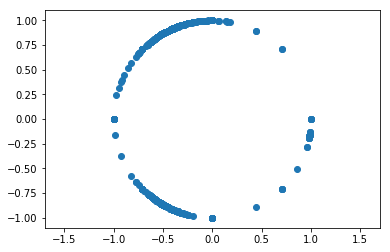

In [4]:
# ploting single points
f, ax1 = plt.subplots(1, 1)
plt.axis('equal')
ax1.scatter(amerge_x, amerge_y)
plt.show()
f.savefig('report/latexSource/imgs/Amerge_all_strokes.png')

In [6]:
X = amerge

lowest_bic = np.infty
bic = []
n_components_range = range(1,100)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

best_gmm.get_params()

{'covariance_type': 'full',
 'init_params': 'kmeans',
 'max_iter': 100,
 'means_init': None,
 'n_components': 44,
 'n_init': 1,
 'precisions_init': None,
 'random_state': None,
 'reg_covar': 1e-06,
 'tol': 0.001,
 'verbose': 0,
 'verbose_interval': 10,
 'warm_start': False,
 'weights_init': None}

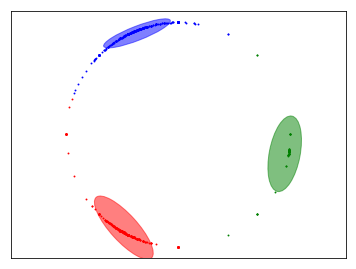

{'covariance_type': 'full',
 'init_params': 'kmeans',
 'max_iter': 100,
 'means_init': None,
 'n_components': 3,
 'n_init': 1,
 'precisions_init': None,
 'random_state': None,
 'reg_covar': 1e-06,
 'tol': 0.001,
 'verbose': 0,
 'verbose_interval': 10,
 'warm_start': False,
 'weights_init': None}

In [8]:
gmm = mixture.GaussianMixture(n_components=3, covariance_type='full')
gmm.fit(amerge)
Y_ = gmm.predict(amerge)
f, ax1 = plt.subplots(1, 1)
color_iter = itertools.cycle(['green', 'blue', 'red'])
for i, (mean, cov, color) in enumerate(zip(gmm.means_, gmm.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    plt.scatter(amerge[Y_ == i, 0], amerge[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(ax1.bbox)
    ell.set_alpha(.5)
    ax1.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.axis('equal')
plt.show()
f.savefig('report/latexSource/imgs/Amerge_gmm_3n.png')
gmm.get_params()

In [16]:
def count_angle(v):
    return np.arctan2(v[0], v[1])
amerge_ang = [[count_angle(x)] for x in amerge]

def vm_pdf(x, mu, kappa):
    return (np.exp(kappa * np.cos(x - mu)))/(2 * np.pi * sc.special.iv(0, kappa))

def vm_score(p, vmm):
    mus = [count_angle(x) for x in vmm.cluster_centers_]
    kappas = vmm.concentrations_
    weights = vmm.weights_
    x = count_angle(p)
    return sum([weight * vm_pdf(x, mu, kappa) for weight, mu, kappa in zip(weights, mus, kappas)])

from sklearn.utils.fixes import logsumexp
def vm_score_sample(X, vmm):
    return np.array([np.log(vm_score(x, vmm)) for x in X])

def bic(lghood, c_samples, c_params):
        return (-2 * lghood + c_params * np.log(c_samples))

In [12]:
vmm = VonMisesFisherMixture(n_clusters=3, init='k-means++')
vmm.fit(amerge)
vmm.get_params()

{'copy_x': True,
 'force_weights': None,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 3,
 'n_init': 10,
 'n_jobs': 1,
 'normalize': True,
 'posterior_type': 'soft',
 'random_state': None,
 'tol': 1e-06,
 'verbose': False}

E:\Python\Python36\lib\site-packages\matplotlib\contour.py:1537: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


TypeError: vm_score_sample() missing 1 required positional argument: 'vmm'

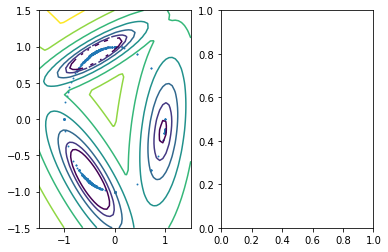

In [12]:
x = np.linspace(-1.5, 1.5)
y = np.linspace(-1.5, 1.5)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

f, [ax1, ax2] = plt.subplots(1, 2)
# Gaussian mixture
Z = -gmm.score_samples(XX)
Z = Z.reshape(X.shape)    
CS = ax1.contour(X, Y, Z, norm=mpl.colors.LogNorm(vmin=1.0, vmax=100.0), levels=np.logspace(0, 3, 10))
#CB = plt.colorbar(CS, shrink=0.8, extend='both')
ax1.scatter(amerge_x, amerge_y, .8)
# Von Mises mixtur
Z = -vm_score_sample(XX)
Z = Z.reshape(X.shape)    
CS = ax2.contour(X, Y, Z, norm=mpl.colors.LogNorm(vmin=1.0, vmax=100.0), levels=np.logspace(0, 3, 10))
#CB = plt.colorbar(CS, shrink=0.8, extend='both')
ax2.scatter(amerge_x, amerge_y, .8)

ax1.axis('equal')
ax2.axis('equal')
#ax1.set_xlim((-1.5, 1.5))
#ax1.set_ylim((-1.5, 1.5))
#ax2.set_xlim((-1.5, 1.5))
#ax2.set_ylim((-1.5, 1.5))
plt.show()
f.savefig('report/latexSource/imgs/Amerge_gmm.png')

In [13]:
def plot_gmm_vm(file_name, gmm, vmm, data):
    x = np.linspace(-1.5, 1.5)
    y = np.linspace(-1.5, 1.5)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    lg_space = np.logspace(0, 2, 10)
    lg_norm = mpl.colors.LogNorm(vmin=1.0, vmax=100.0)
    
    f, ax = plt.subplots(1, 1)
    # Gaussian mixture
    Z = -gmm.score_samples(XX)
    Z = Z.reshape(X.shape)    
    CS = ax.contour(X, Y, Z, norm=lg_norm, levels=lg_space)
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    # Von Mises mixtur
    Z = -vm_score_sample(XX, vmm)
    Z = Z.reshape(X.shape)    
    CS = ax.contour(X, Y, Z, norm=lg_norm, levels=lg_space)
    #CB = plt.colorbar(CS, shrink=0.8, extend='both')
    
    
    data_x = [point[0] for point in data]
    data_y = [point[1] for point in data]
    ax.scatter(data_x, data_y, .8)
    ax.axis('equal')
    plt.show()
    f.savefig('report/latexSource/imgs/' + file_name)


-690.649117043
1407.51367663


E:\Python\Python36\lib\site-packages\matplotlib\contour.py:1537: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


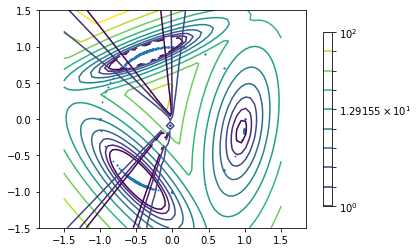

In [19]:
print(gmm.bic(amerge))
print(bic(sum(vm_score_sample(amerge, vmm)), len(amerge), 3))
plot_gmm_vm('Amerge_gmm_vmm_3n', gmm, vmm, amerge)

396.378996066
2142.64707517


E:\Python\Python36\lib\site-packages\matplotlib\contour.py:1537: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


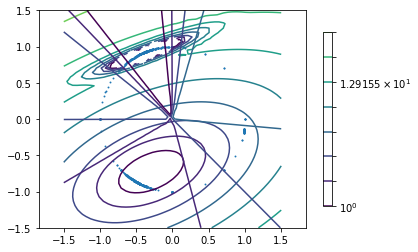

In [15]:
gmm2 = mixture.GaussianMixture(n_components=2, covariance_type='full')
gmm2.fit(amerge)
vmm2 = VonMisesFisherMixture(n_clusters=2, init='k-means++')
vmm2.fit(amerge)


print(gmm2.bic(amerge))
print(bic(vm_score_sample(amerge, vmm2).mean(), len(amerge), 2))
plot_gmm_vm('Amerge_gmm_vmm_2n', gmm2, vmm2, amerge)

In [21]:
np.log(len(amerge))

6.7934661325800096